In [2]:
import numpy as np
import pandas as pd
import harmonica as hm
import matplotlib.pyplot as plt
import verde as vd
import pygmt
import xarray as xr

In [3]:
from polartoolkit import fetch, maps, profiles, regions, utils

In [4]:
df = pd.read_csv('Ice_Bridge.csv')
df

,Unnamed: 0,line,easting,northing,height,levelling_correction,free_air_gravity_70s,free_air_gravity_100s,free_air_gravity_140s
0,0,1,-1607779.38,-664002.11,2009.76,-27.22,-25.44,-22.90,2.571
1,1,1,-1607716.48,-664037.89,2007.32,-27.28,-25.52,-22.93,2.636
2,2,1,-1607653.90,-664074.24,2004.90,-27.33,-25.59,-22.96,2.681
3,3,1,-1607591.63,-664111.16,2002.50,-27.37,-25.65,-22.98,2.701
4,4,1,-1607529.69,-664148.65,2000.14,-27.41,-25.72,-23.01,2.696
...,...,...,...,...,...,...,...,...,...
286816,286816,813,-1599351.77,-664273.84,1846.01,-13.54,-13.73,-13.59,1.429
286817,286817,813,-1599336.04,-664217.09,1847.17,-13.52,-13.75,-13.63,1.446
286818,286818,813,-1599319.95,-664160.38,1848.24,-13.51,-13.77,-13.67,1.477
286819,286819,813,-1599303.50,-664103.71,1849.24,-13.49,-13.78,-13.71,1.513


In [5]:
df = df.groupby('line')

blocked_dfs = []
for name, line in df:
    blocked = utils.block_reduce(
        line,
        np.median,
        spacing=1000,
        center_coordinates=False,
        input_coord_names=["easting", "northing"],
        input_data_names=line.columns.drop(['line']),
    )
    blocked['line'] = name
    blocked_dfs.append(blocked)

df = pd.concat(blocked_dfs).reset_index(drop=True).sort_values(by=['line'])
df

,easting,northing,Unnamed: 0,height,levelling_correction,free_air_gravity_70s,free_air_gravity_100s,free_air_gravity_140s,line
0,-1298647.205,-1121505.575,9599.5,519.825,-31.120,-30.365,-31.530,0.3965,1
1,-1298081.250,-1121755.710,9591.0,520.110,-29.920,-29.330,-31.050,2.1550,1
2,-1297079.125,-1122101.570,9576.5,516.855,-27.815,-27.735,-30.255,2.8595,1
3,-1296068.680,-1122307.070,9562.5,519.770,-25.960,-26.480,-29.505,1.7525,1
4,-1295076.060,-1122422.220,9549.0,518.980,-24.570,-25.560,-28.740,1.3700,1
...,...,...,...,...,...,...,...,...,...
27836,-1433380.030,-664192.695,284849.5,1271.810,24.955,24.110,28.555,0.1560,813
27837,-1389963.950,-664333.075,285399.5,2448.690,63.725,65.865,72.395,0.1410,813
27838,-1389378.370,-664833.115,285388.5,2446.840,61.695,61.600,67.040,0.9035,813
27839,-1365774.920,-664322.795,284860.5,2411.960,-30.070,-29.515,-25.360,2.8605,813


# fit an equivalent source model to the data

In [6]:
eqs = hm.EquivalentSources(
    damping=0.001,
    depth="default",
    block_size=5e3, # block reduce the data, use this to speed up testing but reduce value / remove for final run
)

eqs.fit((df.easting, df.northing, df.height), df.free_air_gravity_70s)

,damping,0.001
,points,None
,depth,'default'
,block_size,5000.0
,parallel,True
,dtype,'float64'


In [7]:
# Build the grid coordinates and set elevation as extra_coords (height for upward continuation)
grid_coords = vd.grid_coordinates(region=regions.getz_ice_shelf , spacing=2000, extra_coords=1000)
grid_coords


(array([[-1624000., -1622000., -1620000., ..., -1134000., -1132000.,
         -1130000.],
        [-1624000., -1622000., -1620000., ..., -1134000., -1132000.,
         -1130000.],
        [-1624000., -1622000., -1620000., ..., -1134000., -1132000.,
         -1130000.],
        ...,
        [-1624000., -1622000., -1620000., ..., -1134000., -1132000.,
         -1130000.],
        [-1624000., -1622000., -1620000., ..., -1134000., -1132000.,
         -1130000.],
        [-1624000., -1622000., -1620000., ..., -1134000., -1132000.,
         -1130000.]], shape=(286, 248)),
 array([[-1234000., -1234000., -1234000., ..., -1234000., -1234000.,
         -1234000.],
        [-1232000., -1232000., -1232000., ..., -1232000., -1232000.,
         -1232000.],
        [-1230000., -1230000., -1230000., ..., -1230000., -1230000.,
         -1230000.],
        ...,
        [ -668000.,  -668000.,  -668000., ...,  -668000.,  -668000.,
          -668000.],
        [ -666000.,  -666000.,  -666000., ...,  -66600

In [8]:
bedmap_surface = fetch.bedmap3(
    layer="surface",
    region = regions.getz_ice_shelf ,
    spacing=2000,
    reference="ellipsoid",
    # this is need to fill offshore nans with 0,
    # note, will fill with 0 geoidal height, then convert to ellipsoidal heights
    fill_nans=True,
)


bedmap_surface = bedmap_surface.rename({'x': 'easting', 'y': 'northing'})

In [9]:
grid_coords = (
    bedmap_surface.easting.values,
    bedmap_surface.northing.values,
    bedmap_surface.values + 500
)
grid_coords

(array([-1624000., -1622000., -1620000., -1618000., -1616000., -1614000.,
        -1612000., -1610000., -1608000., -1606000., -1604000., -1602000.,
        -1600000., -1598000., -1596000., -1594000., -1592000., -1590000.,
        -1588000., -1586000., -1584000., -1582000., -1580000., -1578000.,
        -1576000., -1574000., -1572000., -1570000., -1568000., -1566000.,
        -1564000., -1562000., -1560000., -1558000., -1556000., -1554000.,
        -1552000., -1550000., -1548000., -1546000., -1544000., -1542000.,
        -1540000., -1538000., -1536000., -1534000., -1532000., -1530000.,
        -1528000., -1526000., -1524000., -1522000., -1520000., -1518000.,
        -1516000., -1514000., -1512000., -1510000., -1508000., -1506000.,
        -1504000., -1502000., -1500000., -1498000., -1496000., -1494000.,
        -1492000., -1490000., -1488000., -1486000., -1484000., -1482000.,
        -1480000., -1478000., -1476000., -1474000., -1472000., -1470000.,
        -1468000., -1466000., -1464000

In [10]:

# Predict the gravity disturbance on the grid
grav = eqs.grid(grid_coords, data_names = ['gravity_disturbance'])

grav = vd.convexhull_mask((df.easting, df.northing), grid=grav)

In [11]:
dampings = [0.01, 0.1, 1, 10,]
depths = [5e3, 10e3, 20e3, 50e3]

import itertools

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

Number of combinations: 16
Combinations: [{'damping': 0.01, 'depth': 5000.0}, {'damping': 0.01, 'depth': 10000.0}, {'damping': 0.01, 'depth': 20000.0}, {'damping': 0.01, 'depth': 50000.0}, {'damping': 0.1, 'depth': 5000.0}, {'damping': 0.1, 'depth': 10000.0}, {'damping': 0.1, 'depth': 20000.0}, {'damping': 0.1, 'depth': 50000.0}, {'damping': 1, 'depth': 5000.0}, {'damping': 1, 'depth': 10000.0}, {'damping': 1, 'depth': 20000.0}, {'damping': 1, 'depth': 50000.0}, {'damping': 10, 'depth': 5000.0}, {'damping': 10, 'depth': 10000.0}, {'damping': 10, 'depth': 20000.0}, {'damping': 10, 'depth': 50000.0}]


In [13]:
'''
eqs = hm.EquivalentSources()

scores = []
for params in parameter_sets:
    # set the damping and depth parameters
    eqs.set_params(**params)

    # fit the equivalent sources, and compute the cross-validation score
    score = np.mean(
        vd.cross_val_score(
            eqs,
            (df.easting, df.northing, df.height),
            df.free_air_gravity_70s,
        )
    )
    scores.append(score)
scores

AttributeError: The following error was raised: 'DummyEstimator' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or alternatively define `__sklearn_tags__` but we don't recommend this approach). Note that `BaseEstimator` needs to be on the right side of other Mixins in the inheritance order.

In [12]:
'''
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

ValueError: attempt to get argmax of an empty sequence

In [14]:
'''
eqs_best = hm.EquivalentSources(**parameter_sets[best]).fit(
     (df.easting, df.northing, df.height), df.free_air_gravity_70s,
)

# Predict the gravity disturbance on the grid
grav = eqs_best.grid(grid_coords, data_names = ['gravity_disturbance'])

NameError: name 'best' is not defined

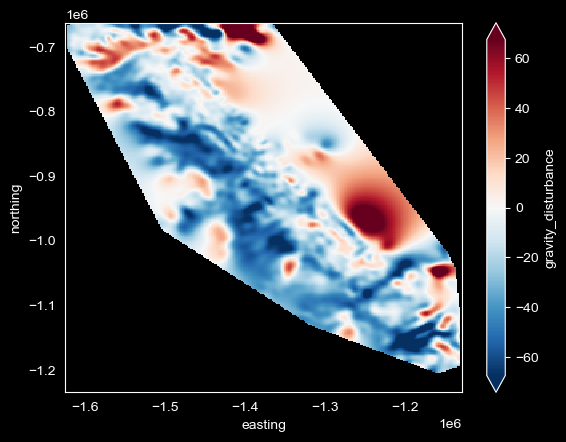

In [15]:
grav
grav.gravity_disturbance.plot(robust=True)

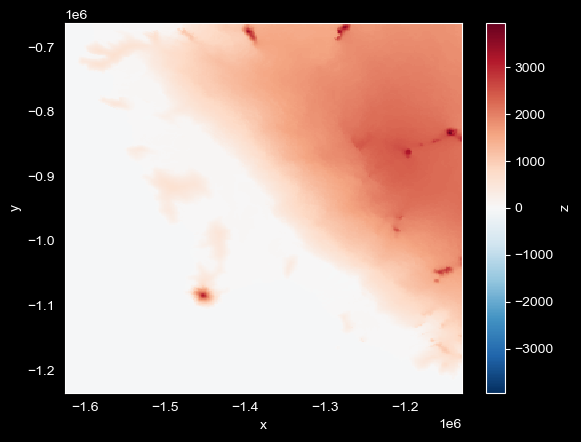

In [16]:
'''
bedmap_surface = fetch.bedmap3(
    layer="surface",
    region = regions.getz_ice_shelf ,
    spacing=2000,
    reference="ellipsoid",
    # this is need to fill offshore nans with 0,
    # note, will fill with 0 geoidal height, then convert to ellipsoidal heights
    fill_nans=True,
)
'''
bedmap_surface.plot()

bedmap_surface = bedmap_surface.rename({'x': 'easting', 'y': 'northing'})

In [17]:
density_contrast = 917 - 1
zref = 0

# density contrasts are positive above the reference level, negative below
density_grid = xr.where(
    bedmap_surface >= zref,
    density_contrast,
    -density_contrast,
)

# create prism layer from ice surface and density grid
surface_prisms = hm.prism_layer(
    coordinates=(
        bedmap_surface.easting.to_numpy(),
        bedmap_surface.northing.to_numpy(),
    ),
    surface=bedmap_surface,
    reference= zref,
    properties={"density": density_grid},
)

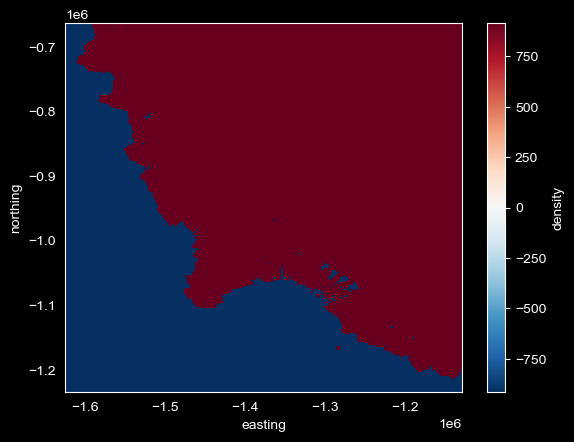

In [18]:
surface_prisms.density.plot()

In [19]:
# convert dataset to DataFrame for easier handling
grav_df = grav.to_dataframe().reset_index()

grav_df["surface_gravity"] = surface_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# convert from dataframe back to xarray dataset
grav = grav_df.set_index(["northing", "easting"]).to_xarray()

  0%|          | 0/70928 [00:00<?, ?it/s]

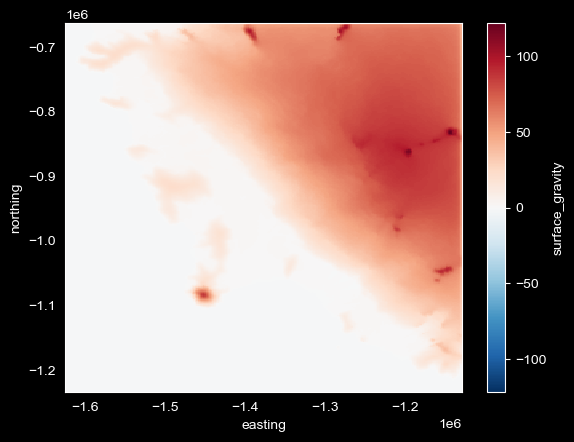

In [20]:
grav.surface_gravity.plot()

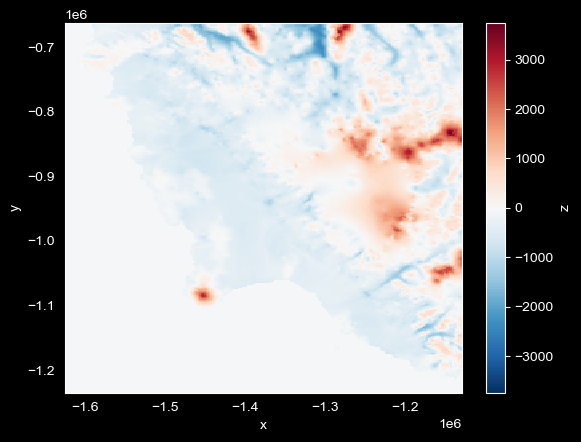

In [21]:
bedmap_water_surface = fetch.bedmap3(
    layer="icebase",
    region = regions.getz_ice_shelf ,
    spacing=2000,
    reference="ellipsoid",
    # this is need to fill offshore nans with 0,
    # note, will fill with 0 geoidal height, then convert to ellipsoidal heights
    fill_nans=True,
)

bedmap_water_surface.plot()

bedmap_water_surface = bedmap_water_surface.rename({'x': 'easting', 'y': 'northing'})

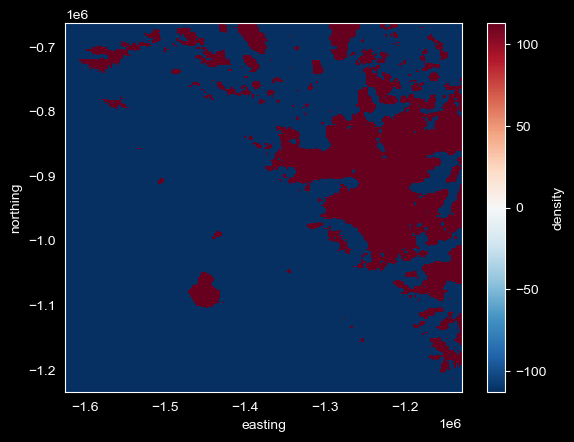

In [22]:
density_contrast = 1030 - 917
zref = 0

# density contrasts are positive above the reference level, negative below
density_grid = xr.where(
    bedmap_water_surface >= zref,
    density_contrast,
    -density_contrast,
)

# create prism layer from ice surface and density grid
water_surface_prisms = hm.prism_layer(
    coordinates=(
        bedmap_water_surface.easting.to_numpy(),
        bedmap_water_surface.northing.to_numpy(),
    ),
    surface=bedmap_water_surface,
    reference=zref,
    properties={"density": density_grid},
)
water_surface_prisms.density.plot()

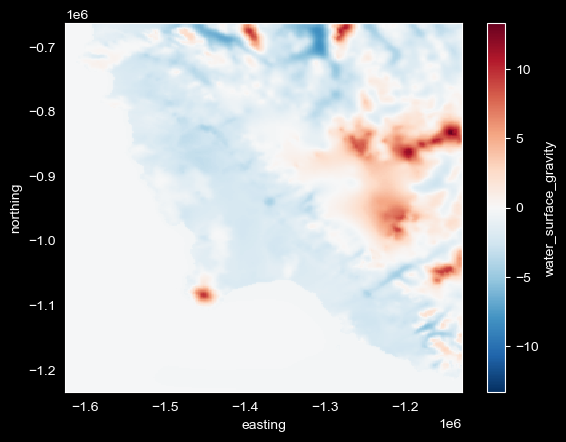

In [23]:

# convert dataset to DataFrame for easier handling
grav_df = grav.to_dataframe().reset_index()

grav_df["water_surface_gravity"] = water_surface_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# convert from dataframe back to xarray dataset
grav = grav_df.set_index(["northing", "easting"]).to_xarray()
grav.water_surface_gravity.plot()

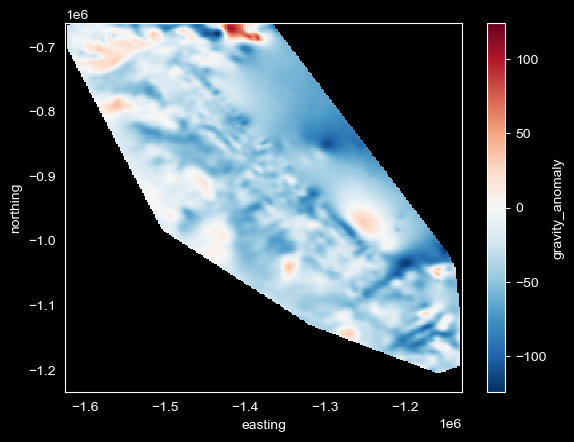

In [24]:
grav['gravity_anomaly'] = grav.gravity_disturbance - grav.surface_gravity - grav.water_surface_gravity

grav.gravity_anomaly.plot()

In [25]:
grav.to_netcdf('gravityanomaly.nc')

add